In [1]:
%matplotlib inline

import os
import sys
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# matplotlib.style.use('ggplot')

plt.rcParams["figure.figsize"] = (16, 9)

print 'Fetching important packages'

Fetching important packages


In [2]:
data_dir = '../data'

def strtodate(s):
    try:
        return datetime.strptime(s, '%d/%m/%Y')
    except ValueError as e:
        pass # let it pass

    try:
        return datetime.strptime(s, '%Y-%m-%d')
    except ValueError as e:
        raise

epoch = datetime.utcfromtimestamp(0)

print 'Get something set up'

Get something set up


In [3]:
train_csvpath = os.path.join(data_dir, 'train.csv')
train_data = pd.read_csv(train_csvpath,
    dtype={
        'Store': int,
        'DayOfWeek': int,
        'Sales': int,
        'Customers': int,
        'Promo': int,
        'StateHoliday': str,
        'SchoolHoliday': int,
    },
    parse_dates=['Date'],
    date_parser=strtodate
    )

train_data.sort_values(['Date', 'Store'],
    axis=0,
    inplace=True,
    ascending=True)

print '\'train.csv\' loaded into pandas'

'train.csv' loaded into pandas


In [4]:
def get_sma(arr, n=30):
    sz  = arr.size

    # Not the best method
    SMA = np.cumsum(arr, axis=None, dtype=float)

    for i in range(min(n, sz)):
        SMA[i] /= (i + 1)

    for i in range(n, sz):
        SMA[i] = SMA[i - 1] + (arr.item(i) - arr.item(i - n)) / n

    return SMA

print 'get_sma() is used to calculate Simple Moving Average'

get_sma() is used to calculate Simple Moving Average


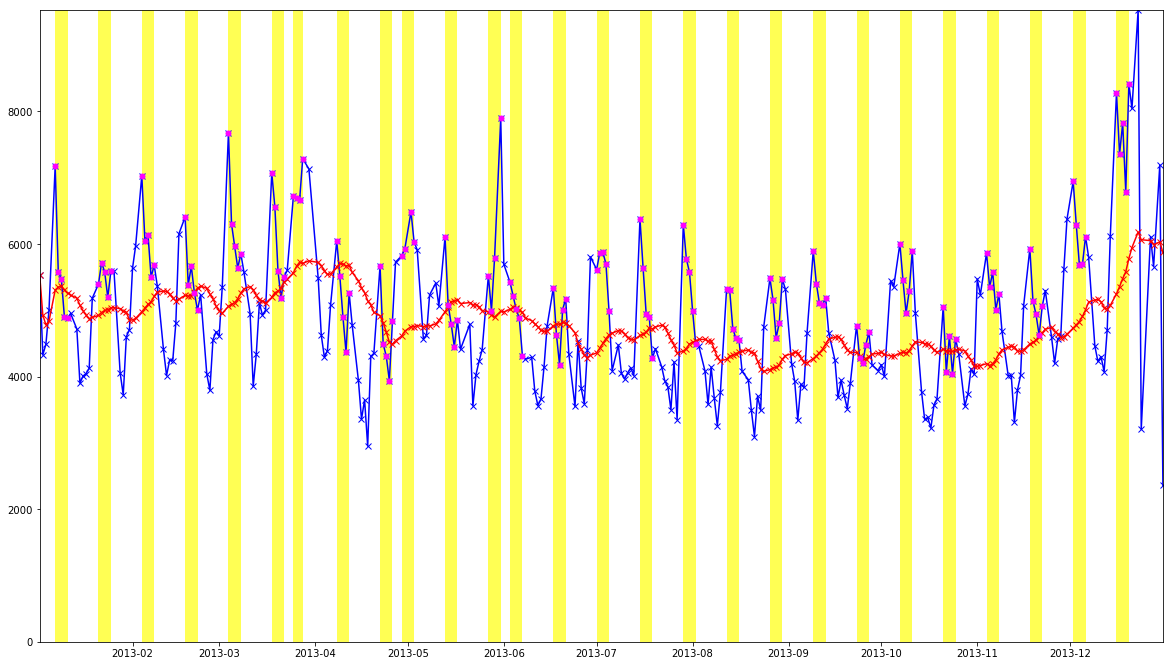

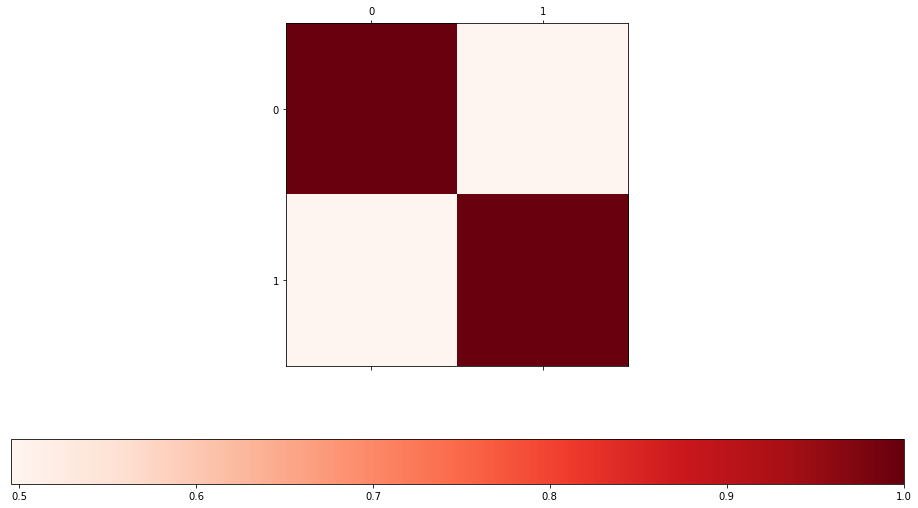

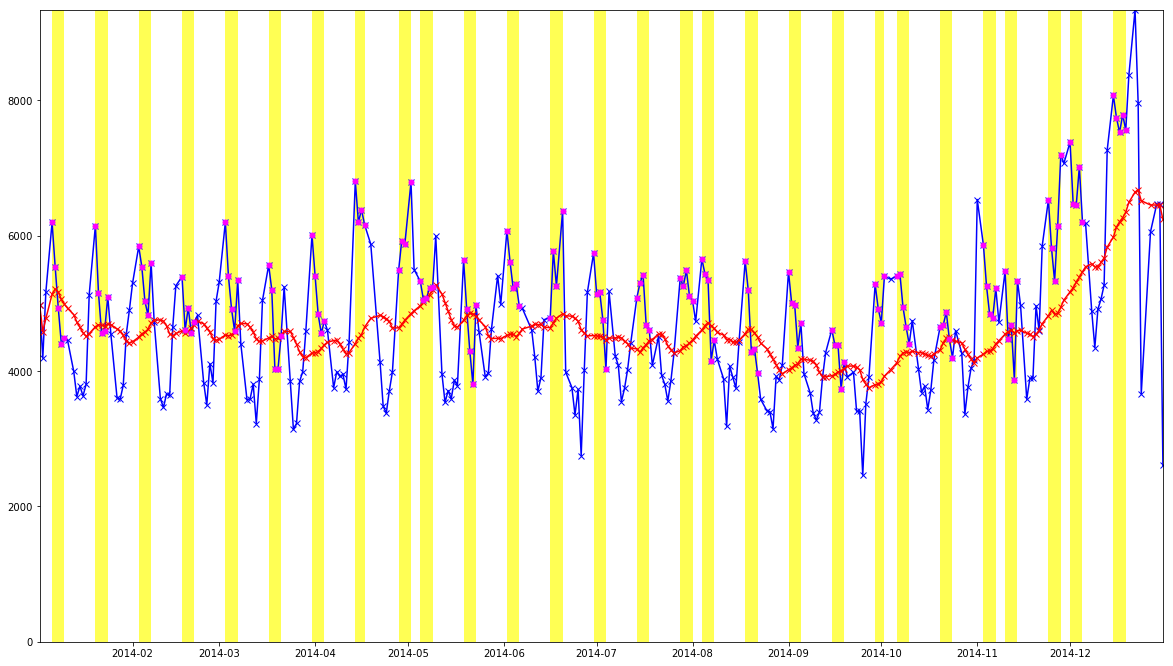

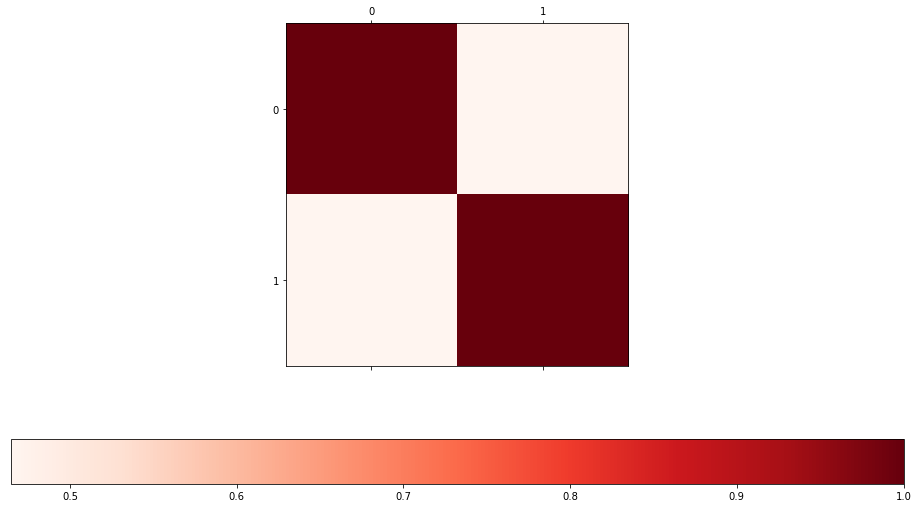

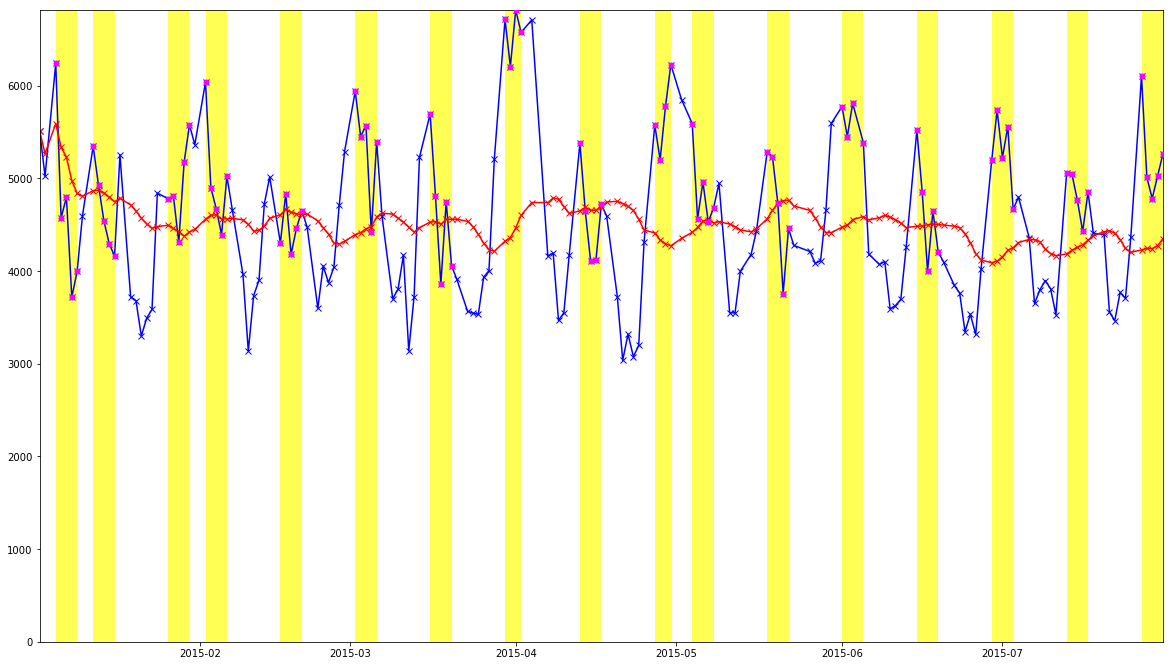

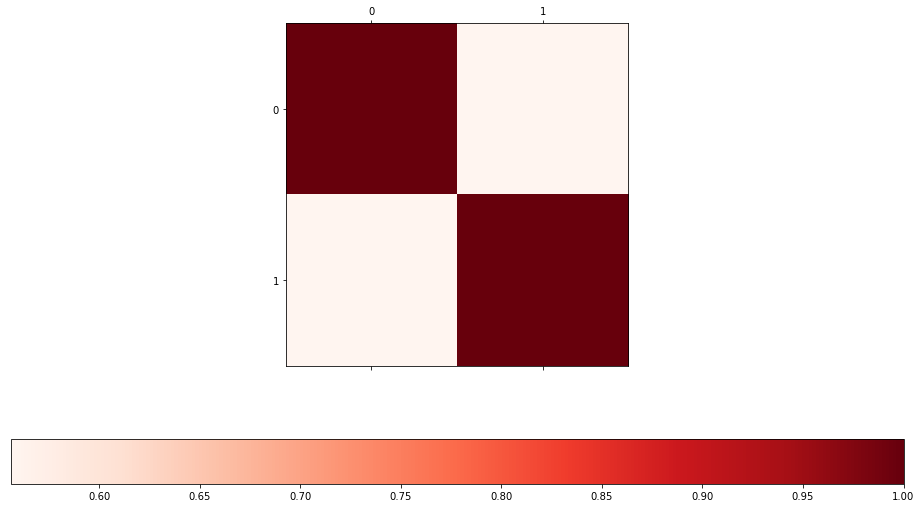

In [5]:
num_stores = 1115
for i in range(1, 2):
    filtered = train_data[
        (train_data['Store']==i) & (train_data['Open']==1)][
        ['DayOfWeek', 'Date', 'Sales', 'Customers', 'Promo',
        'StateHoliday', 'SchoolHoliday']]

    dates   = filtered['Date']
    sales   = filtered['Sales']
    promos  = filtered['Promo']

    sales_promos_pair = filtered[['Sales', 'Promo']]

    for j in range(0, 3):
        year = 2013 + j

        mask        = (dates.dt.year == year).as_matrix()
        mask_wp     = ((dates.dt.year == year) & (promos == 1)).as_matrix()
        dates_allyr = dates[mask].as_matrix()
        sales_allyr = sales[mask].as_matrix()
        promos_allyr = promos[mask].as_matrix()

        dates_wp    = dates[mask_wp].as_matrix()
        sales_wp    = sales[mask_wp].as_matrix()

        SMA21 = get_sma(sales_allyr, n=21)
        sales_promos_corrmat = sales_promos_pair[mask].corr()

        plt.clf()
        plt.figure(1)
        ax = plt.subplot(1, 1, 1)
        plt.fill_between(dates_allyr, 0, sales_allyr.max(), where=promos_allyr > 0, interpolate=False, zorder=0, alpha=0.67, facecolor='yellow')
        plt.plot(dates_allyr, sales_allyr, '-bx', zorder=1)
        plt.plot(dates_allyr, SMA21, '-rx', zorder=2)
        plt.scatter(dates_wp, sales_wp, marker='o', c='magenta', s=25, zorder=3)
        plt.xlim((dates_allyr[0], dates_allyr[-1]))
        plt.ylim((0, sales_allyr.max()))
        plt.subplots_adjust(top=1., bottom=0.025, right=1., left=0.025, wspace=0., hspace=0.)

        fig = plt.figure(2)
        ax  = fig.add_subplot(1, 1, 1)
        cax = ax.matshow(sales_promos_corrmat, cmap='Reds')
        fig.colorbar(cax, orientation='horizontal')
        plt.show()
